<a href="https://colab.research.google.com/github/ghubnerr/nlp-stuff/blob/main/GPT_Tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Byte-level Encoding: Input Representation (Paper)
Tokenizer: 50,257 possible Tokens
Context Size: 1024 tokens

Attention layer: sees up to 1024 tokens.

### Motivation for Tokenization
- Heart of much weirdness in LLMs i.e.: Spelling, string processing, non-english languages, simple arithmetic, coding in Python (GPT-2), abrutply halting when seeing <|endoftext|>, trailing whitespace, YAML over JSON.

### Tiktokenizer
- https://tiktokenizer.vercel.app

Shown explicitly in colors.
Main examples (GPT-2):

▶ token-ization (2 tokens)

▶ ' at' (includes whitespace)

▶ \[127\]\[ +\]\[ 6\]\[77\]

▶ 'Egg' '.' -- whereas -- 'I'' have'' an'' Egg''.'

*For the same concepts, all of these have different id's*

▶ whitespaces in code -- individually!

<br/>
<hr/>


What we're looking for is the sweet spot of vocabulary size.

In [ ]:
# Strings are immutable sequences of Unicode Code Points
# Defined by the Unicode Consortium (149,813 characters)

"안녕하세요 👋"

ord("h") # -> Gives me the unicode code point #104
ord("👋") # 50504

In [1]:
[ord(x) for x in "안녕하세요 👋"]

[50504, 45397, 54616, 49464, 50836, 32, 128075]

Why not just use these numbers?

▶ Unstable representation

▶ Long vocabulary


<hr>
Encodings: UTF-8, UTF-16, UTF-32 are ways of translating unicode encodings into binary data (byte-strings)

### UTF-8 Encoding: Preferred
Backwards-compatible to the ASCII Text

In [2]:
list("안녕하세요 👋".encode("utf-8"))
# list("안녕하세요 👋".encode("utf-16")) # Wasteful encoding

[236,
 149,
 136,
 235,
 133,
 149,
 237,
 149,
 152,
 236,
 132,
 184,
 236,
 154,
 148,
 32,
 240,
 159,
 145,
 139]

This vocabulary implies that the vocabulary length would only be of 256 characters, and all of our text would be stretched out to very long sequences of bytes. What this does is make the embedding table to be tiny, but the sequences are very long. This is bad because of the finite context length that we can support inside the attention head.

### 💡 Predicting Million-byte Sequences with Multiscale Transformers


# Byte-pair Encoding

Instead of bytes, we iteratively find the pair of tokens that occur the most frequently in a sequence. Once we identify that pair, we replace the pair with a single new token.

i.e.: aaabdaaabac ▶ ZabdZabac (Z=aa)
      ▶ ZYdZYac (Y=ab) ▶ XdXac (ZY = X)

<br>

*here, instead of a sequence of 11 tokens with vocabulary length of 4, we know have 5 tokens but the vocabulary length is 7*

### This optimizes for a compressed training dataset

In [7]:
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."
tokens = text.encode("utf-8") # raw bytes
tokens = list(map(int, tokens))

print("---")
print(text)
print("length:", len(text))
print("---")
print(tokens)
print("length:", len(tokens))
# A lot of the unicode becomes multiple characters

---
Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.
length: 533
---
[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140

In [8]:
# Finding the pair of bytes that work most frequently

def get_stats(ids):
  counts = {}
  for pair in zip(ids, ids[1:]):
    counts[pair] = counts.get(pair, 0) + 1
  return counts

stats = get_stats(tokens)
# print(stats)
print(sorted(((v,k) for k,v in stats.items()), reverse=True))

# First pair (most common) is the first item printed

[(20, (101, 32)), (15, (240, 159)), (12, (226, 128)), (12, (105, 110)), (10, (115, 32)), (10, (97, 110)), (10, (32, 97)), (9, (32, 116)), (8, (116, 104)), (7, (159, 135)), (7, (159, 133)), (7, (97, 114)), (6, (239, 189)), (6, (140, 240)), (6, (128, 140)), (6, (116, 32)), (6, (114, 32)), (6, (111, 114)), (6, (110, 103)), (6, (110, 100)), (6, (109, 101)), (6, (104, 101)), (6, (101, 114)), (6, (32, 105)), (5, (117, 115)), (5, (115, 116)), (5, (110, 32)), (5, (100, 101)), (5, (44, 32)), (5, (32, 115)), (4, (116, 105)), (4, (116, 101)), (4, (115, 44)), (4, (114, 105)), (4, (111, 117)), (4, (111, 100)), (4, (110, 116)), (4, (110, 105)), (4, (105, 99)), (4, (104, 97)), (4, (103, 32)), (4, (101, 97)), (4, (100, 32)), (4, (99, 111)), (4, (97, 109)), (4, (85, 110)), (4, (32, 119)), (4, (32, 111)), (4, (32, 102)), (4, (32, 85)), (3, (118, 101)), (3, (116, 115)), (3, (116, 114)), (3, (116, 111)), (3, (114, 116)), (3, (114, 115)), (3, (114, 101)), (3, (111, 102)), (3, (111, 32)), (3, (108, 108)), (

In [10]:
chr(101), chr(32)

('e', ' ')

 Minting a new token every time we see the most-common pair and swap it out

In [11]:
top_pair = max(stats, key=stats.get) # Ranking by value and getting max key

In [12]:
def merge(ids, pair, idx):
  newids = []
  i = 0
  while i < len(ids):
    # if we're not in the last position and the pair matches, replace it
    if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
      newids.append(idx)
      i += 2
    else:
      newids.append(ids[i])
      i += 1
  return newids

tokens2 = merge(tokens, top_pair, 256)
print(tokens2)
print("length: ", len(tokens2)) # Decreased by 20


[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140, 240, 159, 135, 169, 226, 128, 140, 240, 159, 135, 170, 33, 32, 240, 159, 152, 132, 32, 84, 104, 256, 118, 101, 114, 121, 32, 110, 97, 109, 256, 115, 116, 114, 105, 107, 101, 115, 32, 102, 101, 97, 114, 32, 97, 110, 100, 32, 97, 119, 256, 105, 110, 116, 111, 32, 116, 104, 256, 104, 101, 97, 114, 116, 115, 32, 111, 102, 32, 112, 114, 111, 103, 114, 97, 109, 109, 101, 114, 115, 32, 119, 111, 114, 108, 100, 119, 105, 100, 101, 46, 32, 87, 256, 97, 108, 108, 32, 107, 110, 111, 119, 32, 119, 256, 111, 117, 103, 104, 116, 32, 116, 111, 32, 226, 128, 156

### The more steps we take, the larger the vocabulary and the shorter the sequence: Finding the sweet spot hyperparameter. GPT-4 is 100,000

In [13]:
def get_stats(ids):
  counts = {}
  for pair in zip(ids, ids[1:]):
    counts[pair] = counts.get(pair, 0) + 1
  return counts


def merge(ids, pair, idx):
  newids = []
  i = 0
  while i < len(ids):
    # if we're not in the last position and the pair matches, replace it
    if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
      newids.append(idx)
      i += 2
    else:
      newids.append(ids[i])
      i += 1
  return newids


# ---
vocab_size = 276 # desired final vocab size
num_merges = vocab_size - 256
ids = list(tokens) # copy

merges = {} # (int, int) -> int

for i in range(num_merges):
  stats = get_stats(ids)
  pair = max(stats, key=stats.get)
  idx = 256 + i
  print(f"merging {pair} into a new token {idx}")
  ids = merge(ids, pair, idx)
  merges[pair] = idx

merging (101, 32) into a new token 256
merging (240, 159) into a new token 257
merging (226, 128) into a new token 258
merging (105, 110) into a new token 259
merging (115, 32) into a new token 260
merging (97, 110) into a new token 261
merging (116, 104) into a new token 262
merging (257, 133) into a new token 263
merging (257, 135) into a new token 264
merging (97, 114) into a new token 265
merging (239, 189) into a new token 266
merging (258, 140) into a new token 267
merging (267, 264) into a new token 268
merging (101, 114) into a new token 269
merging (111, 114) into a new token 270
merging (116, 32) into a new token 271
merging (259, 103) into a new token 272
merging (115, 116) into a new token 273
merging (261, 100) into a new token 274
merging (32, 262) into a new token 275


Note that the token 256 is also eligible for merging (just like ZY becomes X). The format of this is more of a binary forest instead of a particular tree

In [14]:
print("tokens length:", len(tokens))
print("ids length:", len(ids))
print(f"compression ration: {len(tokens) / len(ids):.2f}X")

tokens length: 616
ids length: 451
compression ration: 1.37X


The Tokenizer is a completely separate, independent module from the LLM. It has its own training dataset of text (which could be different from the LLM), on which you train the vocabulary using the BPE algorithm. It then translates back and forth between raw text and sequence of tokens.

**The LLM later only ever sees the tokens and never directly deals with any text.**

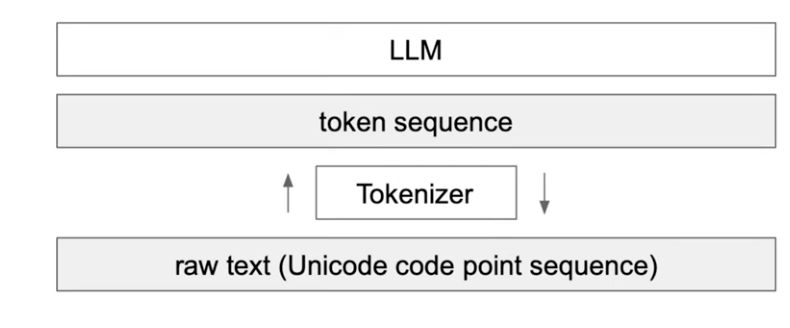

## Decoding
Given a sequence of integers in the range [0, vocab_size], what is the text?

In [15]:
vocab = {idx: bytes([idx]) for idx in range(256)}
for (p0, p1), idx in merges.items():
  vocab[idx] = vocab[p0] + vocab[p1]

def decode(ids):
  # given ids (list of integers), return Python string
  tokens = b"".join(vocab[idx] for idx in ids)
  text = tokens.decode("utf-8", errors="replace")
  return text

## Encoding
The up arrow in the image above. Remember that merges was built from top to bottom (some merges on the way down rely on other merges)

In [17]:
def encode(text):
  tokens = list(text.encode("utf-8"))
  while len(tokens) >= 2:
    stats = get_stats(tokens) # Counting occurrence of pairs as dict

    # For any pair, looking into merges and get pair with min number
    pair = min(stats, key=lambda p: merges.get(p, float("inf")))
    if pair not in merges:
      break # nothing else can be merged
    idx = merges[pair]
    tokens = merge(tokens, pair, idx)

  return tokens

### Not all token sequences are valid byte strings

In [19]:
text2 = decode(encode(text)) # testing with the training data
print(text2 == text)

True


# Tokenization in GPT series
### GPT-2 paper (2019)
Motivating the use of BPE on the Byte-level representation of UTF-8 encoding + Vocabulary sizes.

▶ Common words i.e.: Dog ("dog.", "dog?", "dog!") -- unnecessary clustering

▶ Top-down enforcing some black-lists for pair-encoding.


### Using a Regex pattern
GPT-2 Regex:
```python
re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")
```

In [20]:
!pip install regex

### Forced splits using regex patterns

Re.findall will take the pattern and will try to match it against the input string and organize the occurrences into a list. We're taking the string and instead of directly encoding, we first split it up.

1. Splits the text into a list of texts
2. All the elements of the list are processed individually
3. The results are concatenated

Only find merges within elements of lists. The results of that will be joint.

In [30]:
import regex as re
gpt2pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")

# hardcoded to the apostrophe '   | case sensitive
print(re.findall(gpt2pat, "Hello've world123 HOW's she'll  how's be there!!!?     "))

['Hello', "'ve", ' world', '123', ' HOW', "'s", ' she', "'ll", ' ', ' how', "'s", ' be', ' there', '!!!?', '     ']


In [34]:
example = """
for i in range(1, 101):
    if i % 3 == 0 and i % 5 ==0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
"""

# note that openAI probabaly enforced some sort of enforcement for whitespace
print(re.findall(gpt2pat, example))

['\n', 'for', ' i', ' in', ' range', '(', '1', ',', ' 101', '):', '\n   ', ' if', ' i', ' %', ' 3', ' ==', ' 0', ' and', ' i', ' %', ' 5', ' ==', '0', ':', '\n       ', ' print', '("', 'FizzBuzz', '")', '\n   ', ' elif', ' i', ' %', ' 3', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Fizz', '")', '\n   ', ' elif', ' i', ' %', ' 5', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Buzz', '")', '\n   ', ' else', ':', '\n       ', ' print', '(', 'i', ')', '\n']


In [35]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.4 MB/s eta 0:00:00


### See [tikotken](https://tiktokenizer.vercel.app/)for details

Encoding for GPT-2 on OpenAI Github:

https://github.com/openai/tiktoken/blob/main/tiktoken_ext/openai_public.py


In [36]:
import tiktoken

# GPT-2 (does not merge spaces)
enc = tiktoken.get_encoding("gpt2")
print(enc.encode("    hello world!"))

# GPT-4 (merge spaces)
enc = tiktoken.get_encoding("cl100k_base")
print(enc.encode("    hello world!!!"))

[220, 220, 220, 23748, 995, 0]
[262, 24748, 1917, 12340]


```python
r"""'(?:[sdmt]|ll|ve|re)| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""",
```
▶ Number changes
▶ White-space handling
▶ Case-insensitive

(150k -> 100k vocab size)

In [38]:
!wget https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/vocab.bpe

--2024-02-21 05:43:33--  https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/vocab.bpe
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 20.60.179.33
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|20.60.179.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 456318 (446K) [application/octet-stream]
Saving to: ‘vocab.bpe’

vocab.bpe           100%[===================>] 445.62K  2.33MB/s    in 0.2s    

2024-02-21 05:43:33 (2.33 MB/s) - ‘vocab.bpe’ saved [456318/456318]



In [37]:
!wget https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/encoder.json

--2024-02-21 05:43:31--  https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/encoder.json
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 20.60.179.33
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|20.60.179.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1042301 (1018K) [application/json]
Saving to: ‘encoder.json’

encoder.json        100%[===================>]   1018K  3.48MB/s    in 0.3s    

2024-02-21 05:43:31 (3.48 MB/s) - ‘encoder.json’ saved [1042301/1042301]



In [41]:
import os, json

# -> saving and loading variables for merges and vocab
with open('encoder.json', 'r') as f:
  encoder = json.load(f)

  # encoder equal to vocab object encoder

with open('vocab.bpe', 'r', encoding='utf-8') as f:
  bpe_data = f.read()

  # this is our merges

bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split('\n')[1:-1]]